In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16
from torchvision import transforms
import torch.optim as optim
from PIL import Image, ImageEnhance
import cv2

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])

In [4]:
img = cv2.cvtColor(cv2.imread('trench.jpeg'), cv2.COLOR_BGR2RGB)
img = transform(img)

In [5]:
image = transforms.ToPILImage()(img).convert("RGB")

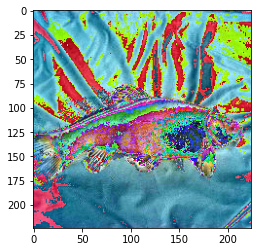

In [6]:
plt.imshow(image)

### Conv Network

In [7]:
class ConvVgg16(nn.Module):
    def __init__(self, save_switches=False):
        super().__init__()
        
        self.save_switches = save_switches
        # indices of Conv2d layres
        self.modules_no = []
        
        self.features = vgg16(pretrained=True).features
        
        for i, feature in enumerate(self.features) :
            if isinstance(feature, nn.MaxPool2d):
                self.features[i] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices = True)
            
            elif isinstance(feature, nn.Conv2d):
                self.modules_no.append(i)
            
        self.avgpool = vgg16(pretrained=True).avgpool
        self.classifier = vgg16(pretrained=True).classifier
                        
        
    def forward (self, x) :
        conv_results = {}
        maxpool_indices = {}
        for i, layer in enumerate(self.features):
            
            if isinstance(layer, nn.MaxPool2d):
                x, index = layer(x)
                maxpool_indices[i] = index
                
            else :
                x = layer(x)
            
            if isinstance(layer, nn.Conv2d):
                conv_results[i] = x
            
        
            
        x = self.avgpool(x)
        x = x.flatten()
        x = self.classifier(x)
        
        
        if not self.save_switches :
            return x    
            
        return x, conv_results, maxpool_indices
    

### Deconv

In [191]:
class ConvDeconvVGG16(nn.Module) :
    def __init__(self) :
        
        super().__init__()
        
        
        self.conv_model = ConvVgg16(save_switches=True)
        
        self.conv_indices = []
        self.maxpool_indices = []
        
        module_list = []
        
        for i, layer in enumerate(self.conv_model.features) :
            if isinstance(layer, nn.Conv2d):
                module_list.append(nn.ConvTranspose2d(layer.out_channels, layer.in_channels, layer.kernel_size, stride=layer.stride, padding=layer.padding))
                module_list[i].weight.data = layer.weight.data
                self.conv_indices.append(i)
                
            elif isinstance(layer, nn.MaxPool2d):
                module_list.append(nn.MaxUnpool2d(kernel_size=2, stride=2))
                self.maxpool_indices.append(i)
                
            elif isinstance(layer, nn.ReLU):
                module_list.append(nn.ReLU(inplace=True))
        
        module_list.reverse()
        self.module_list = nn.ModuleList(module_list)
        
    def forward(self, x, layer_ix) :
        
        conv_pred_vector, conv_results, switches  = self.conv_model(x)
        conv_pred = conv_pred_vector.argmax().item()
        
        y = conv_results[self.conv_indices[layer_ix]]
        # y_idx = y.argmax().item()
        # y_max = y.max().item()
        # y_zerod = torch.zeros_like(y).flatten()
        # y_zerod[y_idx] = y_max
        # y = y_zerod.reshape(y.shape)
        y_sum = y.sum(axis=1).sum(axis=1)
        y_argmax = y_sum.argmax().item()
        y_zerod = torch.zeros_like(y)
        y_zerod[y_argmax, :, :] = y[y_argmax, :, :]
        y = y_zerod
        
        
        
        
        
        
        
        
        
        for i, layer in enumerate(self.module_list[(30 - self.conv_indices[layer_ix]):]) :
            if isinstance(layer, nn.MaxUnpool2d):
                print(f"MaxUnpool2d : {i}")
                y = layer(y, switches[self.conv_indices[layer_ix] - i])
            else :
                y = layer(y)
                
        ret = {"pred_prob" : conv_pred_vector, "pred" : conv_pred, "conv_results": conv_results,"deconv" : y}
        return ret
        
        

In [192]:
model = ConvDeconvVGG16()

In [233]:
out = model(img, 9)

MaxUnpool2d : 5
MaxUnpool2d : 12
MaxUnpool2d : 17


In [234]:
img_out = out['deconv'].permute(1, 2, 0).detach().cpu().numpy()

In [235]:
img_out = (img_out - img_out.min()) / (img_out.max() - img_out.min())
img_out = (img_out * 255).astype(np.uint8)

In [236]:
# Histogram equalization on img_out
img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
img_out[:, :, 1] = cv2.equalizeHist(img_out[:, :, 1])
img_out[:, :, 2] = cv2.equalizeHist(img_out[:, :, 2])


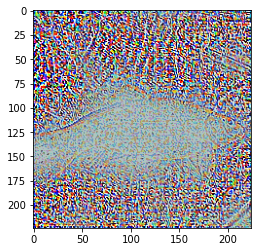

In [237]:
plt.imshow(img_out)